<a href="https://colab.research.google.com/github/A-R-I-N-D-A-M/Machine_leanring-Deep_learning/blob/main/End_to_end_machine_learning_pipeline_using_spark_ML_for_back_order_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps for installing pyspark in colab

In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

In [2]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

In [3]:
!pip install pyspark

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
sns.set()

matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['axes.grid'] = False

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('logregconsult').getOrCreate()

**creating spark dataframe**

In [6]:
file_location = "/content/drive/MyDrive/Dataset/Training_Dataset_v2.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('nanValue', ' ')\
  .option('nullValue', ' ')\
  .load(file_location)

In [7]:
df.show()

+-------+------------+---------+--------------+----------------+----------------+----------------+-------------+-------------+-------------+-------------+--------+---------------+---------------+----------------+-----------------+------------+---------+-------------+---------+-------------+--------+-----------------+
|    sku|national_inv|lead_time|in_transit_qty|forecast_3_month|forecast_6_month|forecast_9_month|sales_1_month|sales_3_month|sales_6_month|sales_9_month|min_bank|potential_issue|pieces_past_due|perf_6_month_avg|perf_12_month_avg|local_bo_qty|deck_risk|oe_constraint|ppap_risk|stop_auto_buy|rev_stop|went_on_backorder|
+-------+------------+---------+--------------+----------------+----------------+----------------+-------------+-------------+-------------+-------------+--------+---------------+---------------+----------------+-----------------+------------+---------+-------------+---------+-------------+--------+-----------------+
|1026827|           0|     null|           

**basic exploratory data analysis**

In [9]:
df.printSchema()

root
 |-- sku: integer (nullable = true)
 |-- national_inv: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- in_transit_qty: integer (nullable = true)
 |-- forecast_3_month: integer (nullable = true)
 |-- forecast_6_month: integer (nullable = true)
 |-- forecast_9_month: integer (nullable = true)
 |-- sales_1_month: integer (nullable = true)
 |-- sales_3_month: integer (nullable = true)
 |-- sales_6_month: integer (nullable = true)
 |-- sales_9_month: integer (nullable = true)
 |-- min_bank: integer (nullable = true)
 |-- potential_issue: string (nullable = true)
 |-- pieces_past_due: integer (nullable = true)
 |-- perf_6_month_avg: double (nullable = true)
 |-- perf_12_month_avg: double (nullable = true)
 |-- local_bo_qty: integer (nullable = true)
 |-- deck_risk: string (nullable = true)
 |-- oe_constraint: string (nullable = true)
 |-- ppap_risk: string (nullable = true)
 |-- stop_auto_buy: string (nullable = true)
 |-- rev_stop: string (nullable = true)
 |--

In [10]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------------+---------+--------------+----------------+----------------+----------------+-------------+-------------+-------------+-------------+--------+---------------+---------------+----------------+-----------------+------------+---------+-------------+---------+-------------+--------+-----------------+
|sku|national_inv|lead_time|in_transit_qty|forecast_3_month|forecast_6_month|forecast_9_month|sales_1_month|sales_3_month|sales_6_month|sales_9_month|min_bank|potential_issue|pieces_past_due|perf_6_month_avg|perf_12_month_avg|local_bo_qty|deck_risk|oe_constraint|ppap_risk|stop_auto_buy|rev_stop|went_on_backorder|
+---+------------+---------+--------------+----------------+----------------+----------------+-------------+-------------+-------------+-------------+--------+---------------+---------------+----------------+-----------------+------------+---------+-------------+---------+-------------+--------+-----------------+
|  0|           0|    64518|             0|            

In [13]:
df.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+---------------+------------------+-------------------+-----------------+-----------------+---------+-------------+---------+-------------+--------+-----------------+
|summary|              sku|     national_inv|        lead_time|    in_transit_qty|  forecast_3_month|  forecast_6_month| forecast_9_month|    sales_1_month|     sales_3_month|     sales_6_month|    sales_9_month|          min_bank|potential_issue|   pieces_past_due|   perf_6_month_avg|perf_12_month_avg|     local_bo_qty|deck_risk|oe_constraint|ppap_risk|stop_auto_buy|rev_stop|went_on_backorder|
+-------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+----------

In [8]:
df_pandas=df.toPandas()

In [9]:
df_pandas.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

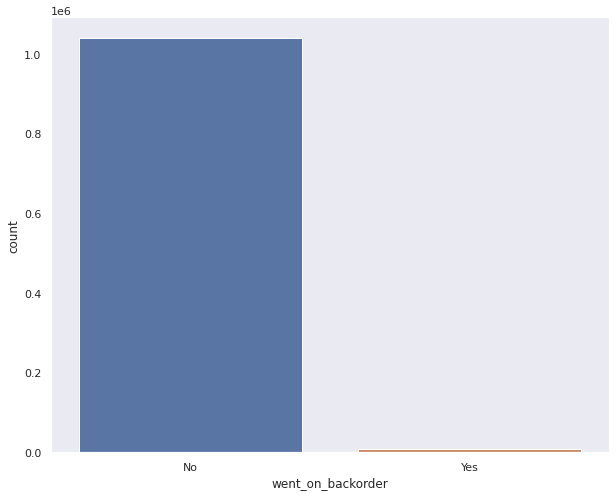

In [12]:
sns.countplot(df_pandas.went_on_backorder)

In [ ]:
# highly imbalanced data

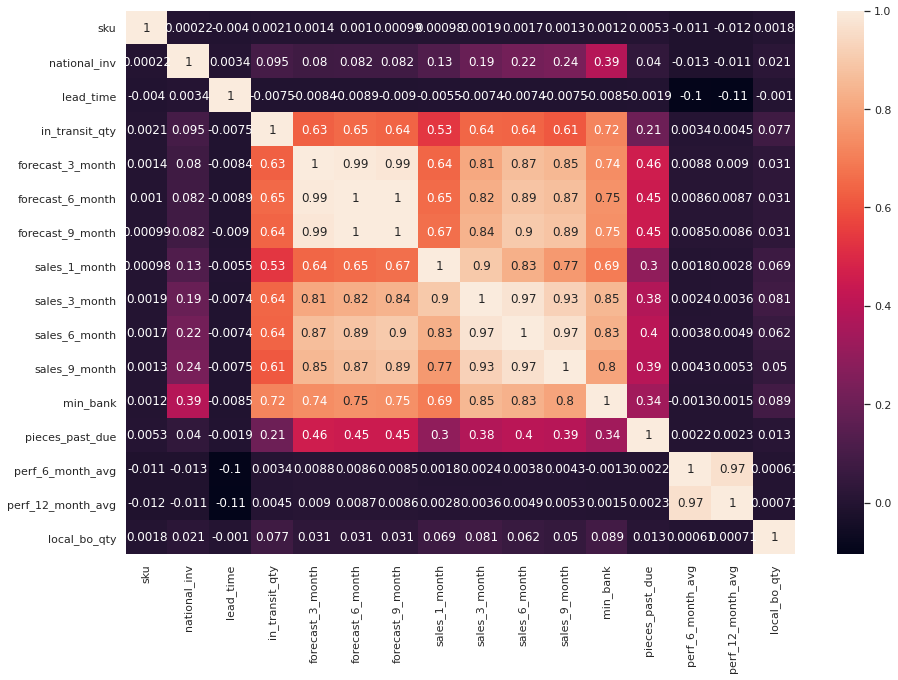

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(df_pandas.corr(),annot=True)

**Steps for creating different transformes for building pipeline**

In [23]:
temp_table_name = "churn_analysis"

df.createOrReplaceTempView(temp_table_name)

In [24]:
churn_df = df
(train_data, test_data) = churn_df.randomSplit([0.7, 0.3])

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 733546
Records for evaluation: 315029


In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

catColumns = ['potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop']

In [26]:
stages= []

for catCol in catColumns:

    stringIndexer = StringIndexer(inputCol=catCol, outputCol=catCol + "Index")

    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[catCol + "catVec"])

    stages += [stringIndexer, encoder]

In [27]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["lead_time"], outputCols=["Out_lead_time"])
stages += [imputer]

In [28]:
label_Idx = StringIndexer(inputCol="went_on_backorder", outputCol="label")
stages += [label_Idx]

In [29]:
temp=label_Idx.fit(train_data).transform(train_data)

In [30]:
numericCols =['national_inv','Out_lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank','pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

In [31]:
assembleInputs = assemblerInputs = [c + "catVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols=assembleInputs, outputCol="features")
stages += [assembler]

In [32]:
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(train_data)

In [33]:
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

In [36]:
trainprepDF.head(1)

[Row(sku=1026827, national_inv=0, lead_time=None, in_transit_qty=0, forecast_3_month=0, forecast_6_month=0, forecast_9_month=0, sales_1_month=0, sales_3_month=0, sales_6_month=0, sales_9_month=0, min_bank=0, potential_issue='No', pieces_past_due=0, perf_6_month_avg=-99.0, perf_12_month_avg=-99.0, local_bo_qty=0, deck_risk='No', oe_constraint='No', ppap_risk='No', stop_auto_buy='Yes', rev_stop='No', went_on_backorder='No', potential_issueIndex=0.0, potential_issuecatVec=SparseVector(1, {0: 1.0}), deck_riskIndex=0.0, deck_riskcatVec=SparseVector(1, {0: 1.0}), oe_constraintIndex=0.0, oe_constraintcatVec=SparseVector(1, {0: 1.0}), ppap_riskIndex=0.0, ppap_riskcatVec=SparseVector(1, {0: 1.0}), stop_auto_buyIndex=0.0, stop_auto_buycatVec=SparseVector(1, {0: 1.0}), rev_stopIndex=0.0, rev_stopcatVec=SparseVector(1, {0: 1.0}), Out_lead_time=7, label=0.0, features=SparseVector(21, {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 7: 7.0, 18: -99.0, 19: -99.0}))]

**model building with logistic regression**

In [37]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainprepDF)

In [38]:
summary=lrModel.summary

**evaluation**

In [39]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall, summary.areaUnderROC))

Accuracy: 0.9915274570374591
FPR: 0.991552204442075
TPR: 0.9915274570374591
F-measure: 0.9873336418449177
Precision: 0.9831751539801328
Recall: 0.9915274570374591
AreaUnderROC: 0.5942700115687315


In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = lrModel.transform(testprepDF)
evaluatorLR = BinaryClassificationEvaluator(rawPredictionCol="prediction",)
area_under_curve = evaluatorLR.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

evaluatorLR.getMetricName()

areaUnderROC = 0.499987


'areaUnderROC'

In [43]:
pred_and_labels = lrModel.evaluate(testprepDF)

In [48]:
pred_and_labels.predictions.show()

+-------+------------+---------+--------------+----------------+----------------+----------------+-------------+-------------+-------------+-------------+--------+---------------+---------------+----------------+-----------------+------------+---------+-------------+---------+-------------+--------+-----------------+--------------------+---------------------+--------------+---------------+------------------+-------------------+--------------+---------------+------------------+-------------------+-------------+--------------+-------------+-----+--------------------+--------------------+--------------------+----------+
|    sku|national_inv|lead_time|in_transit_qty|forecast_3_month|forecast_6_month|forecast_9_month|sales_1_month|sales_3_month|sales_6_month|sales_9_month|min_bank|potential_issue|pieces_past_due|perf_6_month_avg|perf_12_month_avg|local_bo_qty|deck_risk|oe_constraint|ppap_risk|stop_auto_buy|rev_stop|went_on_backorder|potential_issueIndex|potential_issuecatVec|deck_riskIndex